In [1]:
# Run 'pip install -r requirements.txt' to set up necessary packages.
import torch
import torch.nn as nn
from torch.autograd import Variable
from time import time
import dpp_sampler as sampler
import numpy as np
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import pickle

In [2]:
# Sets random seeds for reproducibility.
seed = 412
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# Sets hyperparameters. 
input_size = 2
num_classes = 2
num_epochs = 3000
batch_size = 150
learning_rate = 0.01
max_sample_count = 1000
sub_sample_count = 150
gamma = 5
alpha = 4

In [4]:
# Loads synthetic dataset with sine wave boundaries.
data = torch.Tensor(np.load('./data/data1_train.npy'))
labels = torch.LongTensor(np.load('./data/labels1_train.npy'))
test_data = torch.Tensor(np.load('./data/data1_test.npy'))
test_labels = torch.LongTensor(np.load('./data/labels1_test.npy'))

In [5]:
# Defines methods for saving and loading data.
def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [6]:
# Defines a feed-forward neural network with one hidden layer.
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNN, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(input_size, 4),
            nn.Sigmoid(),
            nn.Linear(4, num_classes)
        )
    
    def forward(self, x):
        out = self.classifier(x)
        return nn.functional.softmax(out, dim=1)
    
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [7]:
# Trains a neural network on a given training set and evaluates the network on a given test set.
def train_and_test(train_imgs, train_lbls, test_imgs, test_lbls, verbose=True, batch_size=batch_size):
    model = DNN(input_size, num_classes)
    
    criterion = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

    for epoch in range(num_epochs):
        shuffle_ids = torch.randperm(train_lbls.shape[0])
        train_imgs = train_imgs[shuffle_ids]
        train_lbls = train_lbls[shuffle_ids]
        
        # Adam optimization with batches
        for i in range(train_lbls.shape[0] // batch_size):
            images = train_imgs[i*batch_size : (i+1)*batch_size]
            labels = train_lbls[i*batch_size : (i+1)*batch_size]

            images = Variable(images)
            labels = Variable(labels)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if verbose and (i+1) % (train_lbls.shape[0] // batch_size) == 0:
                print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                       % (epoch+1, num_epochs, i+1, len(train_lbls)//batch_size, loss.data[0]))


    # Calculate training accuracy
    images = train_imgs[:]
    labels = train_lbls[:]

    images = Variable(images)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum()



    # Calculate test accuracy
    images = test_imgs[:]
    labels = test_lbls[:]

    images = Variable(images)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum()

    return model, float(correct)/total

In [8]:
# Defines a method for displaying the training points that have been selected.
def draw(points):
    plt.scatter([x for x, y in points], [y for x, y in points])
    plt.xlim(-3*np.pi, 3*np.pi)
    plt.ylim(-3*np.pi, 3*np.pi)
    plt.gca().set_aspect('equal')
    plt.pause(0.05)

In [9]:
# Defines a method for training on the entire training set.
def full_model():
    print("Full")
    model, test_acc = train_and_test(data, labels, test_data, test_labels, verbose=False, batch_size=200)
    print('Accuracy of the model on the test images: %d %%' % (100 * correct / total))
    return test_acc

# Defines a method for Uniform Sampling.
def random_subset():
    print("Uniform")
    sub_ids = torch.randperm(labels.shape[0])
    train_ids = sub_ids[:sub_sample_count]
    model, test_acc = train_and_test(data[train_ids], labels[train_ids], test_data, test_labels, verbose=False)
    print('Accuracy of the model on the test images: %d %%' % (100 * test_acc))
    draw(data[train_ids].numpy())
    return test_acc

# Defines a method for Passive DPP (steps = 1000) and Passive Greedy-DPP (steps = 0), where steps is the 
# number of Monte Carlo steps.
def passive_dpp(steps):
    if steps == 0:
        print("Passive Greedy-DPP")
    else:
        print("Passive DPP")
        
    train_ids = sampler.sample_ids_mc(data.numpy(), np.ones(labels.shape[0]), k=sub_sample_count, alpha=alpha, gamma=0., steps=steps)
    train_ids = torch.LongTensor(np.array(train_ids))

    model, test_acc = train_and_test(data.index_select(0, train_ids), labels.index_select(0, train_ids), test_data, test_labels, verbose=False)
    print('Accuracy of the model on the test images: %d %%' % (100 * test_acc))
    draw(data[train_ids].numpy())
    return test_acc

# Defines a method for Active DPP (steps = 1000) and Active Greedy-DPP (steps = 0), where steps is the 
# number of Monte Carlo steps.
def active_dpp(steps):
    if steps == 0:
        print("Active Greedy-DPP")
    else:
        print("Active DPP")
    scores = np.ones(labels.shape[0])
    train_ids = []
    
    # Select batches of training points in ten iterations.
    batches = [sub_sample_count//10]*10

    for i in range(len(batches)):
        # Select 2/3 of batch for exploitation and 1/3 of batch for exploration.
        k = int(np.ceil(2.0*batches[i]/3))
        new_train_ids = sampler.sample_ids_mc(data.numpy(), scores, k=k, alpha=alpha, gamma=gamma, cond_ids=train_ids, steps=steps)
        train_ids = np.append(train_ids, new_train_ids).astype(np.int)
        new_train_ids = sampler.sample_ids_mc(data.numpy(), scores, k=batches[i]-k, alpha=alpha, gamma=0., cond_ids=train_ids, steps=steps)
        train_ids = np.append(train_ids, new_train_ids).astype(np.int)

        mask = np.full(labels.shape[0], True, dtype=bool)
        mask[train_ids] = False
        remaining_ids = np.arange(labels.shape[0])[mask]

        # Estimate uncertainty of each training point with an ensemble of ten neural networks.
        num_models = 10
        out = np.zeros((num_models,data.shape[0],num_classes))
        models = []
        for j in range(num_models):
            train_ids = torch.LongTensor(np.array(train_ids))
            remaining_ids = torch.LongTensor(np.array(remaining_ids))
            m, test_acc = train_and_test(data.index_select(0, train_ids), labels.index_select(0, train_ids), data.index_select(0, remaining_ids), labels.index_select(0, remaining_ids), verbose=False, batch_size=len(train_ids))
            models.append(m)
            out[j,:,:] = models[j](to_var(data)).data.numpy()
        
        # Generate Shannon information entropy for each training point.
        out = np.mean(out, axis=0)
        scores = np.sum(-out*np.log(out),axis=1)
        scores[scores!=scores] = 0 # because 0*log(0)=0
        scores = scores + 1e-8 # just to make sure condition is not zero-probability

    model, test_acc = train_and_test(data[train_ids], labels[train_ids], test_data, test_labels, verbose=False, batch_size=len(train_ids))
    print('Accuracy of the model on the test images: %d %%' % (100 * test_acc))
    draw(data[train_ids].numpy())
    
    return test_acc

# Defines a method for epsilon-Greedy. Here, we use epsilon = 1/3, the proportion of the batch selected by exploration.
def epsilon_greedy():
    print("epsilon-Greedy")
    scores = np.ones(labels.shape[0])
    train_ids = []
    
    # Select batches of training points in ten iterations.
    batches = [sub_sample_count//10]*10

    for i in range(len(batches)):
        # Select 2/3 of batch for exploitation and 1/3 of batch for exploration.
        k = int(np.ceil(2.0*batches[i]/3))
        if i==0:
            new_train_ids = np.random.permutation(labels.shape[0])[:k]
        else:
            new_train_ids = np.argsort(-scores)[:k]
        train_ids = np.append(train_ids, new_train_ids).astype(np.int)
        new_train_ids = []
        while len(new_train_ids) < batches[i] - k:
            tmp = np.random.randint(labels.shape[0])
            if (tmp not in train_ids) and (tmp not in new_train_ids):
                new_train_ids.append(tmp)
        train_ids = np.append(train_ids, new_train_ids).astype(np.int)

        mask = np.full(labels.shape[0], True, dtype=bool)
        mask[train_ids] = False
        remaining_ids = np.arange(labels.shape[0])[mask]
        
        # Estimate uncertainty of each training point with an ensemble of ten neural networks.
        num_models = 10
        out = np.zeros((num_models,data.shape[0],num_classes))
        models = []
        for j in range(num_models):
            train_ids = torch.LongTensor(np.array(train_ids))
            remaining_ids = torch.LongTensor(np.array(remaining_ids))
            m, test_acc = train_and_test(data.index_select(0, train_ids), labels.index_select(0, train_ids), data.index_select(0, remaining_ids), labels.index_select(0, remaining_ids), verbose=False, batch_size=len(train_ids))
            models.append(m)
            out[j,:,:] = models[j](to_var(data)).data.numpy()
        
        # Generate Shannon information entropy for each training point.
        out = np.mean(out, axis=0)
        scores = np.sum(-out*np.log(out),axis=1)
        scores[scores!=scores] = 0 # because 0*log(0)=0
        scores = scores # just to make sure condition is not zero-probability

    model, test_acc = train_and_test(data.index_select(0, train_ids), labels.index_select(0, train_ids), test_data, test_labels, verbose=False, batch_size=len(train_ids))
    print('Accuracy of the model on the test images: %d %%' % (100 * test_acc))
    draw(data[train_ids].numpy())
    
    return test_acc


Uniform
Accuracy of the model on the test images: 71 %


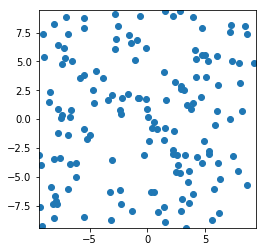

Passive DPP
Accuracy of the model on the test images: 84 %


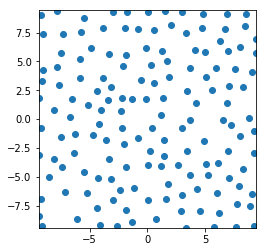

Passive Greedy-DPP
Accuracy of the model on the test images: 85 %


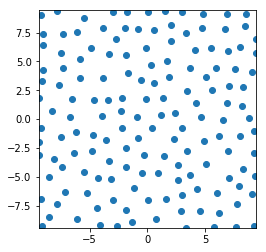

epsilon-Greedy
Accuracy of the model on the test images: 69 %


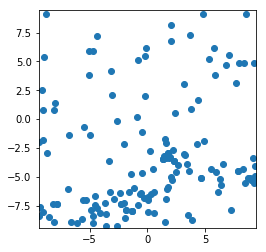

Active DPP
Accuracy of the model on the test images: 84 %


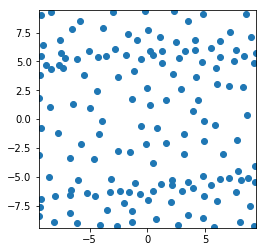

Active Greedy-DPP
Accuracy of the model on the test images: 84 %


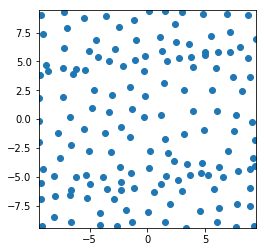

In [10]:
# Runs the experiment for one trial and displays the training points selected.
num_trials = 1

test_acc_random = []
test_acc_passive = []
test_acc_passive_greedy = []
test_acc_epsilon = []
test_acc_active = []
test_acc_active_greedy = []

for i in range(num_trials):
    test_acc_random.append(random_subset())
    test_acc_passive.append(passive_dpp(1000))
    test_acc_passive_greedy.append(passive_dpp(0))
    test_acc_epsilon.append(epsilon_greedy())
    test_acc_active.append(active_dpp(1000))
    test_acc_active_greedy.append(active_dpp(0))